In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=4

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=4


In [2]:
import torch
import jax
import jax.numpy as jnp
import flax
from entmax_jax import sparsemax
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display, HTML
from functools import partial
import json
from entmax_jax.activations import sparsemax, entmax15
from sklearn.metrics import roc_auc_score, average_precision_score

from meta_expl.explainers import load_explainer
from meta_expl.models import load_model
from meta_expl.data.imdb import load_data, dataloader
from utils import aggregate_pieces

from evaluate_explanations import evaluate_word_level, evaluate_sentence_level, aggregate_pieces

### plot utils

In [91]:
def detokenize(pieces):
    return ''.join(pieces).replace('##', ' ').replace('</s>', ' </s>')

def colorize_twoway(words, color_array, label='GOLD', max_width_shown=1800):
    template_pos = '<span class="barcode"; style="color: black; background-color: rgba(3, 252, 94, {}); display:inline-block;">&nbsp{}&nbsp</span>'
    template_neg = '<span class="barcode"; style="color: black; background-color: rgba(252, 161, 3, {}); display:inline-block;">&nbsp{}&nbsp</span>'
    colored_string = ''
    f = lambda w: w.replace('<', 'ᐸ').replace('>', 'ᐳ')
    for word, color in zip(words, color_array):
        if color >= 0:
            colored_string += template_pos.format(color, f(word))
        else:
            colored_string += template_neg.format(-color, f(word))
    html_text = '<div style="width:100%;  font-size:14px; font-family: \'CMU serif\';">{}:&nbsp;&nbsp; {}</div>'.format(label, colored_string)
    display(HTML(html_text))

def show_explanation(tokens, explanation, method='pred'):
    colorize_twoway(tokens, torch.tensor(explanation), label=method)

def plot_attention_map(words, attn_weights, vmax=1, ax=None):
    df = pd.DataFrame(attn_weights, columns=words, index=words)
    sns.heatmap(df, vmax=vmax, cmap="Greens", square=True, cbar=False, ax=ax)

### define args

In [53]:
# arguments
arch = "google/electra-small-discriminator"
num_classes = 2
task_type = "classification"
max_len = 256
batch_size = 32
seed = 1
setup = "static_teacher"

teacher_dir = 'data/imdb-electra-models/teacher_dir'
explainer_dir = 'data/imdb-electra-models/teacher_expl_dir'

In [54]:
# create dummy inputs for model instantiation
input_ids = jnp.ones((batch_size, max_len), jnp.int32)
dummy_inputs = {
    "input_ids": input_ids,
    "attention_mask": jnp.ones_like(input_ids),
    "token_type_ids": jnp.arange(jnp.atleast_2d(input_ids).shape[-1]),
    "position_ids": jnp.ones_like(input_ids),
}
dummy_inputs['input_ids'].shape

(32, 256)

In [55]:
# load data
valid_data = load_data(setup, "dev")
test_data = load_data(setup, "test")

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

### load tokenizer

In [56]:
from transformers import ElectraTokenizerFast
tokenizer = ElectraTokenizerFast.from_pretrained(arch)
vocab_size = len(tokenizer)
cls_id = tokenizer.cls_token_id
sep_id = tokenizer.sep_token_id
pad_id = tokenizer.pad_token_id

### load models and explainers

In [8]:
teacher, teacher_params, dummy_state = load_model(teacher_dir, dummy_inputs, batch_size, max_len)
teacher_explainer, teacher_explainer_params = load_explainer(explainer_dir, dummy_inputs, state=dummy_state)

In [9]:
from meta_expl.utils import PRNGSequence
from meta_expl.explainers import create_explainer
keyseq = PRNGSequence(11)
teacher_explainer_params_non_trained={
    'normalize_head_coeffs': 'sparsemax',
    'normalizer_fn': 'softmax',
    'aggregator_idx': 'mean',
    'aggregator_dim': 'row',
    'init_fn': 'uniform',
    'layer_idx': None,
    'head_idx': None
}
teacher_explainer_non_trained, teacher_explainer_params_non_trained = create_explainer(
    key=next(keyseq),
    inputs=dummy_inputs,
    state=dummy_state,
    explainer_type='attention_explainer',
    explainer_args=teacher_explainer_params_non_trained,
)

In [41]:
best_head_teacher_explainer_params={
    'normalize_head_coeffs': 'sparsemax',
    'normalizer_fn': 'softmax',
    'aggregator_idx': 'mean',
    'aggregator_dim': 'row',
    'init_fn': 'uniform',
    'layer_idx': 8,  #9, None
    'head_idx': 2,  #5, None
}
best_head_teacher_explainer, best_head_teacher_explainer_params = create_explainer(
    key=next(keyseq), 
    inputs=dummy_inputs, 
    state=dummy_state, 
    explainer_type='attention_explainer', 
    explainer_args=best_head_teacher_explainer_params
)

In [42]:
best_layer_teacher_explainer_params={
    'normalize_head_coeffs': 'sparsemax',
    'normalizer_fn': 'softmax',
    'aggregator_idx': 'mean',
    'aggregator_dim': 'row',
    'init_fn': 'uniform',
    'layer_idx': 8,  #9, None
    'head_idx': None,  #5, None
}
best_layer_teacher_explainer, best_layer_teacher_explainer_params = create_explainer(
    key=next(keyseq), 
    inputs=dummy_inputs, 
    state=dummy_state, 
    explainer_type='attention_explainer', 
    explainer_args=best_layer_teacher_explainer_params
)

In [85]:
def id_fn(*args, **kwargs):
    return args[0]

input_gradient_teacher_explainer_params={
    'normalizer_fn': id_fn,
}
input_gradient_teacher_explainer, input_gradient_teacher_explainer_params = create_explainer(
    key=next(keyseq), 
    inputs=dummy_inputs, 
    state=dummy_state, 
    explainer_type='gradient_input_explainer', 
    explainer_args=input_gradient_teacher_explainer_params,
    model_extras={
        "grad_fn": teacher.apply(
            teacher_params, dummy_inputs, method=teacher.embeddings_grad_fn
        )
    }
)

In [95]:
int_gradient_teacher_explainer_params={
    'normalizer_fn': id_fn,
}
int_gradient_teacher_explainer, int_gradient_teacher_explainer_params = create_explainer(
    key=next(keyseq), 
    inputs=dummy_inputs, 
    state=dummy_state, 
    explainer_type='integrated_gradients_explainer', 
    explainer_args=int_gradient_teacher_explainer_params,
    model_extras={
        "grad_fn": teacher.apply(
            teacher_params, dummy_inputs, method=teacher.embeddings_grad_fn
        )
    }
)

### look at the coefficients

In [16]:
sparsemax(teacher_explainer_params['params']['head_coeffs']).reshape(12, 4)

DeviceArray([[0.        , 0.        , 0.        , 0.        ],
             [0.        , 0.        , 0.        , 0.        ],
             [0.        , 0.19831145, 0.        , 0.        ],
             [0.        , 0.        , 0.        , 0.        ],
             [0.        , 0.        , 0.        , 0.        ],
             [0.        , 0.        , 0.        , 0.        ],
             [0.12434827, 0.25941166, 0.        , 0.        ],
             [0.        , 0.27521744, 0.        , 0.0986265 ],
             [0.        , 0.        , 0.0440846 , 0.        ],
             [0.        , 0.        , 0.        , 0.        ],
             [0.        , 0.        , 0.        , 0.        ],
             [0.        , 0.        , 0.        , 0.        ]],            dtype=float32)

In [17]:
hc = sparsemax(teacher_explainer_params['params']['head_coeffs']).reshape(12, 4)
for a, b in zip(*hc.nonzero()):
    print(a, b, hc[a,b])

2 1 0.19831145
6 0 0.12434827
6 1 0.25941166
7 1 0.27521744
7 3 0.0986265
8 2 0.044084605


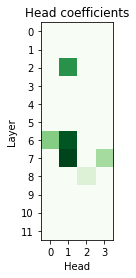

In [84]:
coeffs = np.asarray(hc)
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(coeffs, cmap='Greens')
ax.set_xticks(list(range(4)))
ax.set_yticks(list(range(12)))
ax.set_xlabel('Head')
ax.set_ylabel('Layer')
ax.set_title('Head coefficients')
plt.savefig('head_coeffs_imdb_vertical.pdf', dpi=300, bbox_inches='tight')

### Aggregate scores for word pieces in SRC and MT independently

In [28]:
def get_expl(data, idx, t, t_p, t_e, t_e_p, s=None, s_p=None, s_e=None, s_e_p=None, is_grad_based=False):
    all_tokens = []
    all_masks = []
    all_explanations = []
    all_outputs = []
    for i, (x, y) in enumerate(dataloader([data[idx]], tokenizer, batch_size=1, max_len=max_len, shuffle=False)):
        y_teacher, teacher_attn = t.apply(t_p, **x, deterministic=True)
        y_teacher = jnp.argmax(y_teacher, axis=-1) if task_type == "classification" else y_teacher
        if is_grad_based:
            teacher_extras = {
                "grad_fn": t.apply(t_p, x, method=t.embeddings_grad_fn)
            }
            teacher_expl, _ = t_e.apply(t_e_p, x, teacher_attn, **teacher_extras)
        else:
            teacher_expl, _ = t_e.apply(t_e_p, x, teacher_attn)
        # teacher_rep = teacher_attn['hidden_states'][0][0]
        # teacher_attn = np.asarray(jnp.stack(teacher_attn['attentions']).transpose([1, 0, 2, 3, 4]))
        
        if s is not None:
            y_student, student_attn = s.apply(s_p, **x)
            y_student = jnp.argmax(y_student, axis=-1) if task_type == "classification" else y_student
            student_expl, _ = student_explainer.apply(s_e_p, x, student_attn)
            # student_attn = np.asarray(jnp.stack(student_attn['attentions']).transpose([1, 0, 2, 3, 4]))
        
        # convert everything to lists
        batch_ids = x['input_ids'].tolist()
        batch_tokens = [tokenizer.convert_ids_to_tokens(ids) for ids in batch_ids]
        batch_masks = [[not tk.startswith('##') for tk in tokens] for tokens in batch_tokens]
        batch_expls = teacher_expl.tolist()
        
        # filter out pad
        batch_valid_len = x['attention_mask'].sum(-1).tolist()
        batch_z = []
        for i in range(len(batch_valid_len)):
            n = batch_valid_len[i]
            batch_ids[i] = batch_ids[i][:n]
            batch_tokens[i] = batch_tokens[i][:n]
            batch_masks[i] = batch_masks[i][:n]
            batch_expls[i] = batch_expls[i][:n]
        
        all_tokens.extend(batch_tokens)
        all_masks.extend(batch_masks)
        all_explanations.extend(batch_expls)
        all_outputs.extend(y_teacher.tolist())
        
    return all_tokens[0], all_masks[0], all_explanations[0], all_outputs[0]

In [64]:
sum_norm = lambda v: v / v.sum()
min_max_norm = lambda v: (v - v.min()) / (v.max() - v.min())
std_norm = lambda v: (v - v.mean()) / v.std()
abs_norm = lambda v: v / np.max(np.abs(v))

def show_expl_for_all_methods(idx):
    gold_tokens = valid_data[idx]['text']
    gold_label = valid_data[idx]['label']

    pred_tokens, pred_fp_mask, pred_expl, pred_label = get_expl(
        valid_data,
        idx,
        teacher, 
        teacher_params, 
        teacher_explainer, 
        teacher_explainer_params,
        is_grad_based=False
    )

    print('Idx: {} | Gold: {} | Pred: {}'.format(idx, gold_label, pred_label))
    show_explanation(pred_tokens[1:-1], abs_norm(np.array(pred_expl[1:-1])), method='attention (learned)')


    pred_tokens, pred_fp_mask, pred_expl, pred_label = get_expl(
        valid_data,
        idx,
        teacher, 
        teacher_params, 
        teacher_explainer_non_trained, 
        teacher_explainer_params_non_trained,
        is_grad_based=False
    )
    show_explanation(pred_tokens[1:-1], abs_norm(np.array(pred_expl[1:-1])), method='attention (all layers)')


    pred_tokens, pred_fp_mask, pred_expl, pred_label = get_expl(
        valid_data,
        idx,
        teacher, 
        teacher_params, 
        best_layer_teacher_explainer, 
        best_layer_teacher_explainer_params,
        is_grad_based=False
    )
    show_explanation(pred_tokens[1:-1], abs_norm(np.array(pred_expl[1:-1])), method='attention (best layer)')

    pred_tokens, pred_fp_mask, pred_expl, pred_label = get_expl(
        valid_data,
        idx,
        teacher, 
        teacher_params, 
        best_head_teacher_explainer, 
        best_head_teacher_explainer_params,
        is_grad_based=False
    )
    show_explanation(pred_tokens[1:-1], abs_norm(np.array(pred_expl[1:-1])), method='attention (best head)')


    pred_tokens, pred_fp_mask, pred_expl, pred_label = get_expl(
        valid_data,
        idx,
        teacher, 
        teacher_params, 
        input_gradient_teacher_explainer, 
        input_gradient_teacher_explainer_params,
        is_grad_based=True
    )
    show_explanation(pred_tokens[1:-1], abs_norm(np.array(pred_expl[1:-1])), method='input x gradient')


    pred_tokens, pred_fp_mask, pred_expl, pred_label = get_expl(
        valid_data,
        idx,
        teacher, 
        teacher_params, 
        int_gradient_teacher_explainer, 
        int_gradient_teacher_explainer_params,
        is_grad_based=True
    )
    show_explanation(pred_tokens[1:-1], abs_norm(np.array(pred_expl[1:-1])), method='integrated gradient')

show_expl_for_all_methods(idx=3)

Idx: 3 | Gold: 0 | Pred: 0


In [82]:
for i in range(1000):
    pred_tokens, pred_fp_mask, pred_expl, pred_label = get_expl(
        valid_data,
        i,
        teacher, 
        teacher_params, 
        input_gradient_teacher_explainer, 
        input_gradient_teacher_explainer_params,
        is_grad_based=True
    )
    print(np.min(pred_expl))
# show_explanation(pred_tokens[1:-1], abs_norm(np.array(pred_expl[1:-1])), method='input x gradient')

0.000764263968449086
4.888026615412766e-12
0.00207764795050025
1.665550943223517e-35
0.002163478173315525
0.00019832955149468035
0.0004018099862150848
2.3065220844387113e-08
0.000508072436787188
2.1712178929766957e-11
0.0010674633085727692
0.00031867323559708893
0.0023875865153968334
1.65327213724753e-12
0.00021898465638514608
0.002225772012025118
8.362420977903184e-09
3.635972589677294e-08
0.0006934101693332195
3.7119891203474253e-05
3.966912451194675e-14
0.00036600115709006786
0.0002996025141328573
0.00031210752786137164
1.6600647256836965e-07
0.0011904260609298944
0.0022832315880805254
0.000539234490133822
0.000262831716099754
0.0021819411776959896
0.0
4.848703105686525e-10
0.002568095223978162
0.0
0.0013978059869259596
0.0003204353270120919
1.3418963362710201e-06
0.0014628528151661158
0.00010116697376361117
0.001357156434096396
0.0006628108094446361
1.0510721263999535e-27
0.0013042307691648602
2.2476353478850797e-05
0.0005917156231589615
7.261158896376685e-10
2.4574004783062264e-05

KeyboardInterrupt: 

In [62]:
a=np.argsort(list(map(lambda t: len(t['text'].split()), valid_data)))
b=np.sort(list(map(lambda t: len(t['text'].split()), valid_data)))
list(zip(a,b))

[(16981, 4),
 (21461, 6),
 (17691, 8),
 (21578, 8),
 (13465, 9),
 (13933, 10),
 (7238, 14),
 (21265, 16),
 (16618, 16),
 (10415, 16),
 (12842, 18),
 (22407, 18),
 (12448, 19),
 (2825, 19),
 (22722, 19),
 (10922, 20),
 (387, 20),
 (7383, 21),
 (19953, 21),
 (6959, 21),
 (7483, 22),
 (10332, 22),
 (24236, 22),
 (625, 23),
 (22033, 23),
 (992, 23),
 (24212, 23),
 (10646, 24),
 (18490, 24),
 (21930, 24),
 (3945, 24),
 (1927, 24),
 (6553, 24),
 (9619, 24),
 (18474, 25),
 (8502, 25),
 (1770, 25),
 (24554, 25),
 (23348, 26),
 (22562, 26),
 (21977, 26),
 (13724, 27),
 (24825, 27),
 (259, 28),
 (1418, 28),
 (12039, 28),
 (13185, 28),
 (21905, 28),
 (20373, 28),
 (12513, 28),
 (23587, 28),
 (24185, 28),
 (305, 29),
 (10012, 29),
 (21567, 29),
 (5154, 29),
 (6722, 29),
 (9543, 29),
 (15271, 29),
 (10638, 30),
 (15207, 30),
 (3822, 30),
 (11523, 30),
 (7656, 30),
 (24315, 30),
 (12855, 30),
 (5748, 30),
 (11416, 30),
 (24778, 30),
 (22517, 31),
 (4188, 31),
 (14181, 31),
 (7760, 31),
 (10619, 31),

In [96]:
for i in [6935, 19]:
    show_expl_for_all_methods(idx=i)

Idx: 6935 | Gold: 0 | Pred: 0


Idx: 19 | Gold: 1 | Pred: 1


In [97]:
from random import sample
for i in list(sample(a[:700].tolist(), 50)) + [11208, 6935, 19]:
    show_expl_for_all_methods(idx=i)

Idx: 14754 | Gold: 1 | Pred: 1


Idx: 24778 | Gold: 0 | Pred: 0


Idx: 1322 | Gold: 0 | Pred: 0


Idx: 20203 | Gold: 0 | Pred: 0


Idx: 12275 | Gold: 0 | Pred: 0


Idx: 17400 | Gold: 0 | Pred: 0


Idx: 4021 | Gold: 1 | Pred: 1


Idx: 12319 | Gold: 0 | Pred: 0


Idx: 13185 | Gold: 1 | Pred: 0


Idx: 6012 | Gold: 1 | Pred: 1


Idx: 23747 | Gold: 0 | Pred: 0


Idx: 11706 | Gold: 1 | Pred: 1


Idx: 24585 | Gold: 0 | Pred: 1


Idx: 21074 | Gold: 0 | Pred: 0


Idx: 13327 | Gold: 0 | Pred: 0


Idx: 24161 | Gold: 1 | Pred: 0


Idx: 8428 | Gold: 1 | Pred: 1


Idx: 18444 | Gold: 1 | Pred: 1


Idx: 6935 | Gold: 0 | Pred: 0


Idx: 6722 | Gold: 1 | Pred: 1


Idx: 15708 | Gold: 1 | Pred: 0


Idx: 14560 | Gold: 0 | Pred: 0


Idx: 16230 | Gold: 0 | Pred: 0


Idx: 6834 | Gold: 1 | Pred: 1


Idx: 7271 | Gold: 1 | Pred: 1


Idx: 1510 | Gold: 0 | Pred: 0


Idx: 17812 | Gold: 1 | Pred: 1


Idx: 16366 | Gold: 0 | Pred: 0


Idx: 20830 | Gold: 1 | Pred: 1


Idx: 24903 | Gold: 0 | Pred: 0


Idx: 18490 | Gold: 1 | Pred: 1


Idx: 18691 | Gold: 0 | Pred: 0


Idx: 7674 | Gold: 0 | Pred: 0


Idx: 6649 | Gold: 0 | Pred: 0


Idx: 13397 | Gold: 0 | Pred: 0


Idx: 2781 | Gold: 1 | Pred: 1


Idx: 2825 | Gold: 1 | Pred: 1


Idx: 13630 | Gold: 0 | Pred: 0


Idx: 6487 | Gold: 1 | Pred: 1


Idx: 11277 | Gold: 1 | Pred: 1


Idx: 6828 | Gold: 1 | Pred: 1


Idx: 19724 | Gold: 0 | Pred: 0


Idx: 9844 | Gold: 1 | Pred: 1


Idx: 24973 | Gold: 0 | Pred: 0


Idx: 3894 | Gold: 0 | Pred: 0


Idx: 14205 | Gold: 0 | Pred: 0


Idx: 23204 | Gold: 0 | Pred: 1


Idx: 14472 | Gold: 0 | Pred: 0


Idx: 15089 | Gold: 1 | Pred: 1


Idx: 24264 | Gold: 0 | Pred: 0


Idx: 11208 | Gold: 0 | Pred: 0


Idx: 6935 | Gold: 0 | Pred: 0


Idx: 19 | Gold: 1 | Pred: 1
